# Multigrid Methods

To start here is some recommended literature on multigrid:
- Briggs, Henson, McCormick: A Multigrid Tutorial (2nd ed.), SIAM, 2000.
- Trottenberg, Oosterlee, Schüller: Multigrid, Elsevier, 2001.
- Shapira: Matrix-Based Multigrid: Theory and Applications, Springer, 2008.
- Hackbusch: Iterative Solution of Large Sparse Systems of Equations, Springer 1993.
- Brandt, Livne: Multigrid Techniques: 1984 Guide with Applications to Fluid Dynamics, Revised Edition, SIAM

For a different perspective on multigrid have a look at:
- M. Griebel: Multilevel algorithms considered as iterative methods on semidefinite systems, SIAM Int. J. Sci. Stat. Comput. 15(3), 1994.


### Model problem

#### 1D Poisson Equation

$$ -\frac{d^2}{dx^2} u(x) = f(x), \text{ for } x\in [0,1]$$
$$u(0)=u(1)=0$$


- Discretise on a mesh of $N$ equidistant points $\rightarrow$ linear system to solve
- Recall Finite Difference Schemes (or see tutorial)

In [2]:
import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt
from scipy.sparse import diags
from ipywidgets import interact, FloatSlider, IntSlider

from IPython.display import display, clear_output

fig, ax = plt.subplots()
plt.close(fig)

# Multigrid Idea

- Observation and convergence analysis of smoothers show:
    - “high-frequency error” is relative to mesh size
    - on a sufficiently coarse grid, even very low frequencies can be “high-frequency” (if the mesh size is big)
    
- Multigrid idea:
     - use multiple grids to solve the system of equations
     - hope that on each grid, a certain range of error frequencies will be reduced efficiently

# Nested Iteration

### Solve the problem on a coarser grid:
- will be comparably (very) fast
- can give us a good initial guess:
- leads to “poor man’s multigrid”: nested iteration

# Nested Iteration
### Algorithm:
1. Start on a very coarse grid with mesh size $h = h_0$ 

        - guess an initial solution $x_h$
        
2. Iterate over $A_h x_h = b_h$ using relaxation method

        - approximate solution $x_h$
        
3. interpolate the solution $x_h$ to a finer grid with mesh width $h/2$

4. proceed with step 2 (now with mesh size $h := h/2$) using interpolated $x_{h/2}$ as initial solution

# Nested Iteration

### Recall Gauss-Seidel Smoother

In [22]:
def gaussSeidelRelaxation(A, b, x0, maxIter):
    x = x0  # initial guess
    res = b - np.dot(A,x)                        # initial residual
    for i in range(maxIter):
        for j in range(0,x.size):
            x[j] = (1/A[j,j]) * (b[j] - np.dot(A[j,:],x) + A[j,j]*x[j]); # forward substitution and update
        res = b - np.dot(A,x)  
    return x

# Nested Iteration

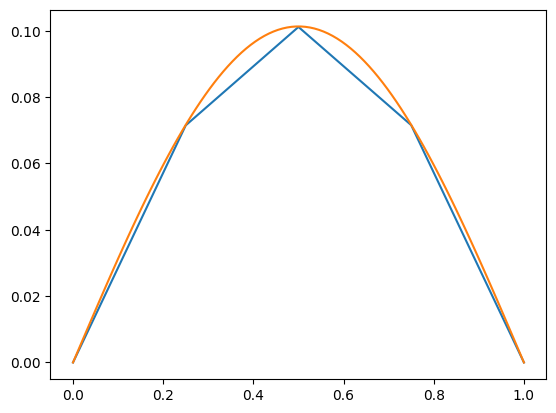

In [28]:
# Get first grid approximation
N = 5; h = 0.25
A = stiffness_matrix(N)
f = rhs(N); x0 = np.zeros(N-2).reshape(-1,1)
u_coarse = gaussSeidelRelaxation(A, f, x0, 10); u_coarse = np.vstack((np.array([[0]]),u_coarse,np.array([[0]])));

ax.clear(); ax.plot(np.linspace(0,1,N), u_coarse); 
ax.plot(np.linspace(0,1,100), 1/np.pi/np.pi*np.sin(np.pi*np.linspace(0,1,100))); display(fig)

# Nested Iteration

### In order to use the result of the coarse grid on a fine grid we need to interpolate

In [8]:
def interpolate(u_coarse):
    u_fine = np.zeros(u_coarse.size*2-1).reshape(-1,1)
    u_fine[::2] = u_coarse # even indices exist on the coarse grid
    u_fine[1::2] = 0.5*(u_coarse[:u_coarse.size-1] + u_coarse[1:]) # linear interpolation
    return u_fine

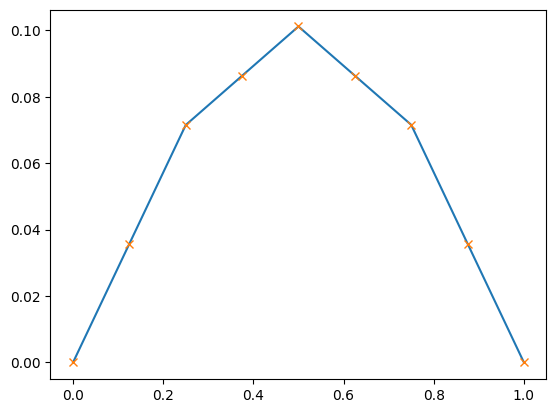

In [31]:
N=9
u_fine = interpolate(u_coarse);
ax.clear(); ax.plot(np.linspace(0,1,5), u_coarse); 
ax.plot(np.linspace(0,1,N), u_fine,"x"); 
display(fig)

# Nested Iteration

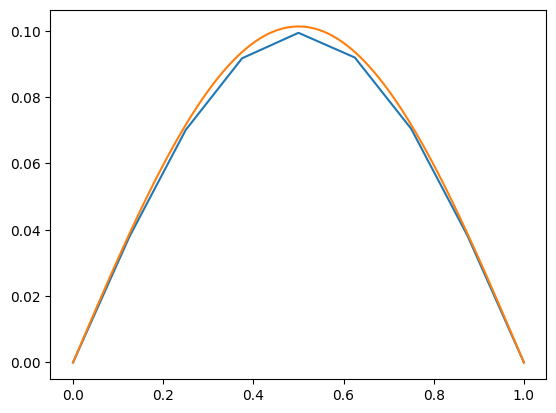

In [34]:
# Use first grid as starting point for refined simulation
N = 9; h = 0.125
A = stiffness_matrix(N)
f = rhs(N); 
#x0 = np.zeros(N-2).reshape(-1,1)
x0 = interpolate(u_coarse)[1:N-1]
u_fine = gaussSeidelRelaxation(A, f, x0, 5); u_fine = np.vstack((np.array([[0]]),u_fine,np.array([[0]])));

ax.clear(); ax.plot(np.linspace(0,1,N), u_fine); 
ax.plot(np.linspace(0,1,100), 1/np.pi/np.pi*np.sin(np.pi*np.linspace(0,1,100))); display(fig)

# Multigrid Idea

### Observation for nested iteration:
- error in interpolated initial guess also includes low frequencies
- relaxation therefore still slow
- can we go “back” to a coarser grid later in the algorithm?

# Multigrid Idea

### Idea No. 2: use the residual equation

##### coarse-grid correction:
- solve Ae = r on a coarser grid
- leads to an approximation of the error e
- add this approximation to the fine-grid solution

# A Two-Grid Method

### Algorithm:
1. relaxation/smoothing on the fine level system $\rightarrow$ solution $x_h$
2. compute the residual $r_h = b_h - A_h x_h$
3. restriction of $r_h$ to the coarse grid with mesh width $H$
4. compute a solution to $A_H e_H = r_H$
5. interpolate the coarse grid solution $e_H$ to the fine grid with mesh width $h$
6. add the resulting correction to $x_h$
7. again, relaxation/smoothing on the fine grid

# Two-Grid Method - Components
### smoother:
- reduce the high-frequency error components, and get a smooth error

### restriction:
- transfer residual from fine grid to coarse grid, e.g. injection, (full) weighting
     
### coarse grid equation:
-  discretisation of the PDE on the coarse grid

### interpolation:
- transfer coarse grid solution/correction from coarse grid to fine grid

# Components

#### We have
- smoother
- coarse grid equation (by direct discretisation $\rightarrow$ other options exist)

#### Missing
- interpolation
- restriction

# Interpolation

- take coarse grid solution and transfer to fine grid
- If transfering from $h \rightarrow h/2$ missing a value for every second coefficient

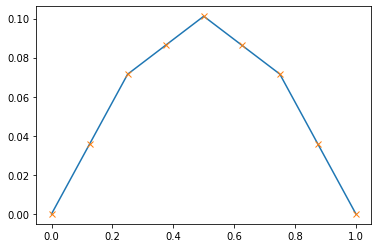

In [619]:
N=9
u_fine = interpolate(u_coarse);
ax.clear(); ax.plot(np.linspace(0,1,5), u_coarse); 
ax.plot(np.linspace(0,1,N), u_fine,"x"); display(fig)

# Interpolation (or Prolongation)

#### In between coarse grid grid points:
1. choose a constant value (ie either value to the side)
     - usually too small approximation error
     - sometimes used for cell-based coarsening (e.g. for FV methods where the cell values are constants)
2. quadratic, cubic, etc.:
      - often too costly
      - more smoothing steps are cheaper and can eliminate the disadvantage of a lower-order interpolation
3. For our current p.w. linear approximation a linear interpolation is reasonable

# Interpolation - Matrix Notation

#### For linear interpolation (1D):
  
$$
  \left(\begin{array}{ccc}
        \frac{1}{2} & 0 & 0 \\
        1 & 0 & 0 \\
        \frac{1}{2} & \frac{1}{2} & 0 \\
        0 & 1 & 0 \\
        0 & \frac{1}{2} & \frac{1}{2} \\
        0 & 0 & 1 \\
        0 & 0 & \frac{1}{2}\\
     \end{array}\right)
     \left(\begin{array}{c}
        x_1 \\ x_2 \\ x_3
\end{array}\right)
=
     \left(\begin{array}{c}
        \frac{1}{2} (0+x_1) \\ x_1 \\ \frac{1}{2} ( x_1+x_2) \\ x_2 \\ 
        \frac{1}{2} ( x_2+x_3) \\ x_3 \\ \frac{1}{2} (x_3+0)
     \end{array}\right)$$
  
#### Notation: $I_{2h} x_{2h} = x_h$ or $P_{2h}x_{2h} = x_h$

#### Note: disregards boundary values (here: 0-Dirichlet condition assumed)

# Interpolation

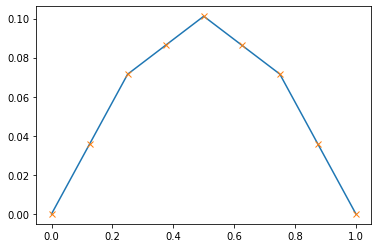

In [620]:
def interpolate(u_coarse):
    u_fine = np.zeros(u_coarse.size*2-1).reshape(-1,1)
    u_fine[::2] = u_coarse # even indices exist on the coarse grid
    u_fine[1::2] = 0.5*(u_coarse[:u_coarse.size-1] + u_coarse[1:]) # linear interpolation
    return u_fine

u_fine = interpolate(u_coarse);
ax.clear(); ax.plot(np.linspace(0,1,5), u_coarse); ax.plot(np.linspace(0,1,9), u_fine,"x"); display(fig)

# Interpolation - Convection-Diffusion

### Example problem: 1D convection-diffusion equation

$$ - \epsilon u_{xx} + c u_{x} = f, \qquad 0 < \epsilon \ll c $$

- consider homogeneous problem ($f=0$) with Dirichlet boundaries: $u(0)=1$, $u(1) = 0$
- exact solution for this case: 

$$ u(x) = \frac{1}{1 - e^{c /\epsilon}} \left( e^{c x /\epsilon} - e^{c /\epsilon} \right) = 1- \frac{ 1- e^{c x /\epsilon} }{1 - e^{c /\epsilon}} $$

# Interpolation - Convection-Diffusion

### Operator-dependent Interpolation:
- interpolate at $x=\frac{1}{2}$:

   $$ u\bigl(\frac{1}{2}\bigr) = 1- \frac{ 1- e^{c /2\epsilon} }{1 - e^{c /\epsilon}} =: 1 - \frac{1-z}{1-z^2} $$ for large $z =e^{\frac{c}{2\epsilon}}$, we have $u\bigl(\frac{1}{2}\bigr) \approx 1 - \frac{1}{z} \approx 1$
   
#### thus: linear interpolation inappropriate (and leads to slow convergence) $\rightarrow$ interpolation should be operator-dependent

# Restriction

### For Poisson problem:
- injection: pick values at corresp. coarse grid points
- full weighting: transpose of bilinear interpolation (safer, more robust convergence), see illustration below for the 1D case

<img src="images/full_weighting.png"></img>

# Restriction - Matrix Notation

### For full weighting (1D):
$$     \frac{1}{2}\left(\!\begin{array}{ccccccc}
        \frac{1}{2} & 1 & \frac{1}{2} & 0 & 0 & 0 & 0\\[0.5ex]
        0 & 0 & \frac{1}{2} & 1 & \frac{1}{2} & 0 & 0\\[0.5ex]
        0 & 0 & 0 & 0 & \frac{1}{2} & 1 & \frac{1}{2}
     \end{array}\!\right) \!\!
     \left(\!\begin{array}{c}
        x_1 \\ x_2 \\ x_3 \\ x_4 \\ x_5 \\ x_6 \\ x_7
     \end{array}\!\right)
     =
     \left(\!\begin{array}{c}
        \frac{1}{4} (x_1+2x_2+x_3) \\[0.5ex] 
        \frac{1}{4} (x_3+2x_4+x_5) \\[0.5ex] 
        \frac{1}{4} (x_5+2x_6+x_7) 
     \end{array}\!\right)$$

#### Notation: $I_{h}^{2h} x_{h} = x_{2h}$ or $R_h^{2h} x_h = x_{2h}$

# Restriction

In [673]:
# Use first grid as starting point for refined simulation
N = 9; h = 0.125
A = stiffness_matrix(N)
f = rhs(N); 
x0 = interpolate(u_coarse)[1:N-1]
u_fine = gaussSeidelRelaxation(A, f, x0, 100); u_fine = np.vstack((np.array([[0]]),u_fine,np.array([[0]])));

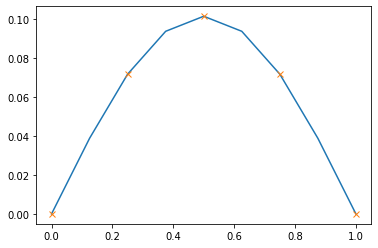

In [677]:
def injection(u_fine):
    N = u_fine.size;   u_coarse = np.zeros(int((N+1)/2)).reshape(-1,1)
    u_coarse = u_fine[0::2]
    return u_coarse
    
u_coarse = injection(u_fine);
ax.clear(); ax.plot(np.linspace(0,1,9), u_fine); 
ax.plot(np.linspace(0,1,5), u_coarse,"x"); display(fig)

# Restriction

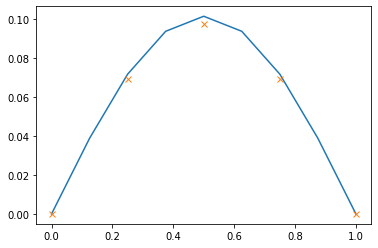

In [683]:
def full_weighting(u_fine):
    N = u_fine.size;     u_f = u_fine[1:N-1]
    u_coarse = np.zeros(int((N+1)/2)).reshape(-1,1)
    u_coarse[1:u_coarse.size-1] = 0.25*(u_f[:N-3][0::2] + 2*u_f[1::2] + u_f[2::2])
    return u_coarse

u_coarse = full_weighting(u_fine);
ax.clear(); ax.plot(np.linspace(0,1,9), u_fine); 
ax.plot(np.linspace(0,1,5), u_coarse,"x"); display(fig)

# Outlook: Multigrid

- Generalise the two grid method to an arbitrary number of grids
- Structure remain: smooth $\rightarrow$ restrict $\rightarrow$ interpolate (repeat)
- V-cycle: recursive call of Two-/Multigrid solver on coarse grids
- W-cycle: perform two coarse grid correction steps instead of one

### Open questions
- Are there other methods of computing the coarse grid operator than discretisation?